In [1]:
wd <- dirname(dirname(getwd()))
source(paste0(wd,"/mission_control/treasure_map.R"))
source(paste0(wd,"/mission_control/helpers/figures/general.R"))
source(paste0(wd,"/mission_control/helpers/figures/exhaustive_plots.R"))
source(paste0(wd,"/mission_control/helpers/figures/exhaustive_settings.R"))
source(paste0(wd,"/mission_control/helpers/figures/themes.R"))

library(tidyverse)
library(ggrepel)
library(RColorBrewer)
library(gridExtra)
library(ggpubr)

Loading required package: ggplot2
Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
── Attaching packages ─────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.2.1 ──
✔ tibble  3.1.2     ✔ purrr   0.3.4
✔ tidyr   1.1.3     ✔ dplyr   1.0.6
✔ readr   1.3.1     ✔ stringr 1.4.0
✔ tibble  3.1.2     ✔ forcats 0.5.1
Warning message:
“package ‘tibble’ was built under R version 3.6.3”Warning message:
“package ‘tidyr’ was built under R version 3.6.3”Warning message:
“package ‘purrr’ was built under R version 3.6.3”Warning message:
“package ‘dplyr’ was built under R version 3.6.3”Warning message:
“package ‘forcats’ was built under R version 3.6.3”── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::combine() masks gridExtra::combine()
✖ dplyr::filter()  masks stats::filter()
✖ dplyr::lag()     masks stats::lag()


In [2]:
base <- readRDS(paste0(TMP_DIR, "supplement-five-extension.Rds"))

In [3]:
o_dir <- paste0(FIG_DIR ,"supplement_main/")
annote <- function( i, lab, size = 20 ) annotate_figure( i, fig.lab = lab, fig.lab.size = size, fig.lab.face = "bold")

#### Prep

In [4]:
base$dataset <- ifelse( base$group == "CPI", "CPI Therapy", "Non-CPI Therapies")

name_map <- list(
    "tmb" = "TMB", "tcell" = "T-cell", "prolif" = "Proliferation", "tgfb" = "TGFB", 
    "pretreat" = "Prior Therapy"
)
base$feature <- unlist(lapply(base$feature , function(i) name_map[[i]]))
base$clean_feature <- unlist(lapply(base$feature , function(i) name_map[[i]]))                              
                                    
p0 <- base %>% filter(group == "CPI")
p1 <- base %>% filter(group != "CPI")

#### Settings 

In [5]:
color_map <- list(
    'Prior Therapy' = '#9E7788',
    'TGFB' = '#BEBADA',
    'Proliferation' = '#8DD3C7',
    'T-cell' = '#FB8072',
    'TMB' = '#80B1D3'
)

base_theme <- theme_classic(base_size = 20)
theme0 <- (
    base_theme + 
    theme(axis.title=element_text(size = 18), 
          plot.margin = unit(c(.5,.1,.5,.1), "cm"),
          legend.position = "none")
)

#### Plot Functions 

In [6]:
e_plot <- function( df, x_axis = "plot_est", y_axis = "log10_p", x_lab = "" , size = 8, base_size = 18, free = FALSE){
    
    aesthetic <- aes( x = .data[[x_axis]], y = .data[[y_axis]], fill = feature)
    
    gg <- (
        ggplot( df, aesthetic )
            + geom_point(shape = 21, size = size)
            + scale_color_manual(values = c("black"))
            + scale_fill_manual(values = unlist(color_map))
            + geom_vline(xintercept = 1, linetype="dashed", color = "black", size=.2) 
            + geom_hline(yintercept = -log10(.05), linetype="dashed", color = "black", size=.3) 
            + labs( x = x_lab, y = "-Log10 (p-value)" )
            + facet_wrap(~ dataset)
            + theme0
        )
    if ( free ){
        gg + facet_wrap(~ dataset, scales = "free_x")
    } else {
        gg + facet_wrap(~ dataset)
    }

}

add_annotation <- function (annotate, x_axis = "plot_est", y_axis = "log10_p", nudge_y = .5, size = 5, push = 1, pull = 1, seed = 622) {
    aesthetic <- aes(x = .data[[x_axis]], y = .data[[y_axis]], label = feature)
    repel_labels <- (
        geom_text_repel(
                data = annotate,
                aesthetic,
                size = size,
                col = "black",
                point.padding = 1e-06,
                alpha = 1,
                force = push,
                force_pull = pull,
                nudge_y = nudge_y,
                max.overlaps = 100,
                min.segment.length = unit(0, 'lines'),
                seed = seed
        )
    )
    repel_labels
}

### 0 - Response Plots

In [7]:
k <- "BOR"
j <- "Response Odds Ratio Estimate"

a0 <- e_plot( p0 %>% filter(nice_response == k), x_lab = j, base_size = 20, size = 12) 
a1 <- add_annotation( p0 %>% filter(nice_response == k), nudge_y = 1.3, size = 6 )
b0 <- e_plot( p1 %>% filter(nice_response == k), x_lab = j, base_size = 20, size = 12) 
b1 <- add_annotation( p1 %>% filter(nice_response == k), nudge_y = 1.3, size = 6 )
r0 <- a0 + a1 
r1 <- b0 + b1 

In [8]:
o1 <- arrangeGrob(r0 + xlim(.2,2.4) + ylim(0, 15), 
                  r1 + xlim(.4,1.5) + ylim(0, 15) + theme(axis.title.y = element_blank(),axis.text.y = element_blank()), 
                  ncol = 2)

#### Survival Plots 

In [9]:
k <- "Overall Survival"
j <- "1/OS Hazard Estimate"

a0 <- e_plot( p0 %>% filter(nice_response == k), x_lab = j, base_size = 20, size = 12) 
a1 <- add_annotation( p0 %>% filter(nice_response == k), nudge_y = 2, size = 6 )
b0 <- e_plot( p1 %>% filter(nice_response == k), x_lab = j, base_size = 20, size = 12) 
b1 <- add_annotation( p1 %>% filter(nice_response == k), nudge_y = 2, size = 6 )

s0 <- a0 + a1 
s1 <- b0 + b1 

In [10]:
o2 <- arrangeGrob(s0 + xlim(.4,1.8) + ylim(0,26), 
                  s1 + xlim(.65,1.3) + ylim(0,26) + theme(axis.title.y = element_blank(), axis.text.y = element_blank()), 
                  ncol = 2)

In [11]:
get_ready <- function( grob, title = "Response", hjust = 0, size = 13, vjust = 0){
    as_ggplot(grob) + ggtitle(title) + theme(plot.margin = unit(rep(.2,4), "cm"), plot.title = element_text(hjust = hjust, size = size, vjust = vjust))
}

In [12]:
response_ready <- get_ready(arrangeGrob(annote(as_ggplot(o1), "A")), title = "Response (tissue adjusted)", hjust = .5, size =21, vjust = 0)
survival_ready <- get_ready(arrangeGrob(annote(as_ggplot(o2), "B")), title = "Survival (tissue adjusted)", hjust = .5, size =21, vjust = 0)
together <- get_ready( arrangeGrob(response_ready, survival_ready), "Five Factors Effect Sizes: CPI vs Non-CPI", hjust = .5, size =22, vjust = 2)

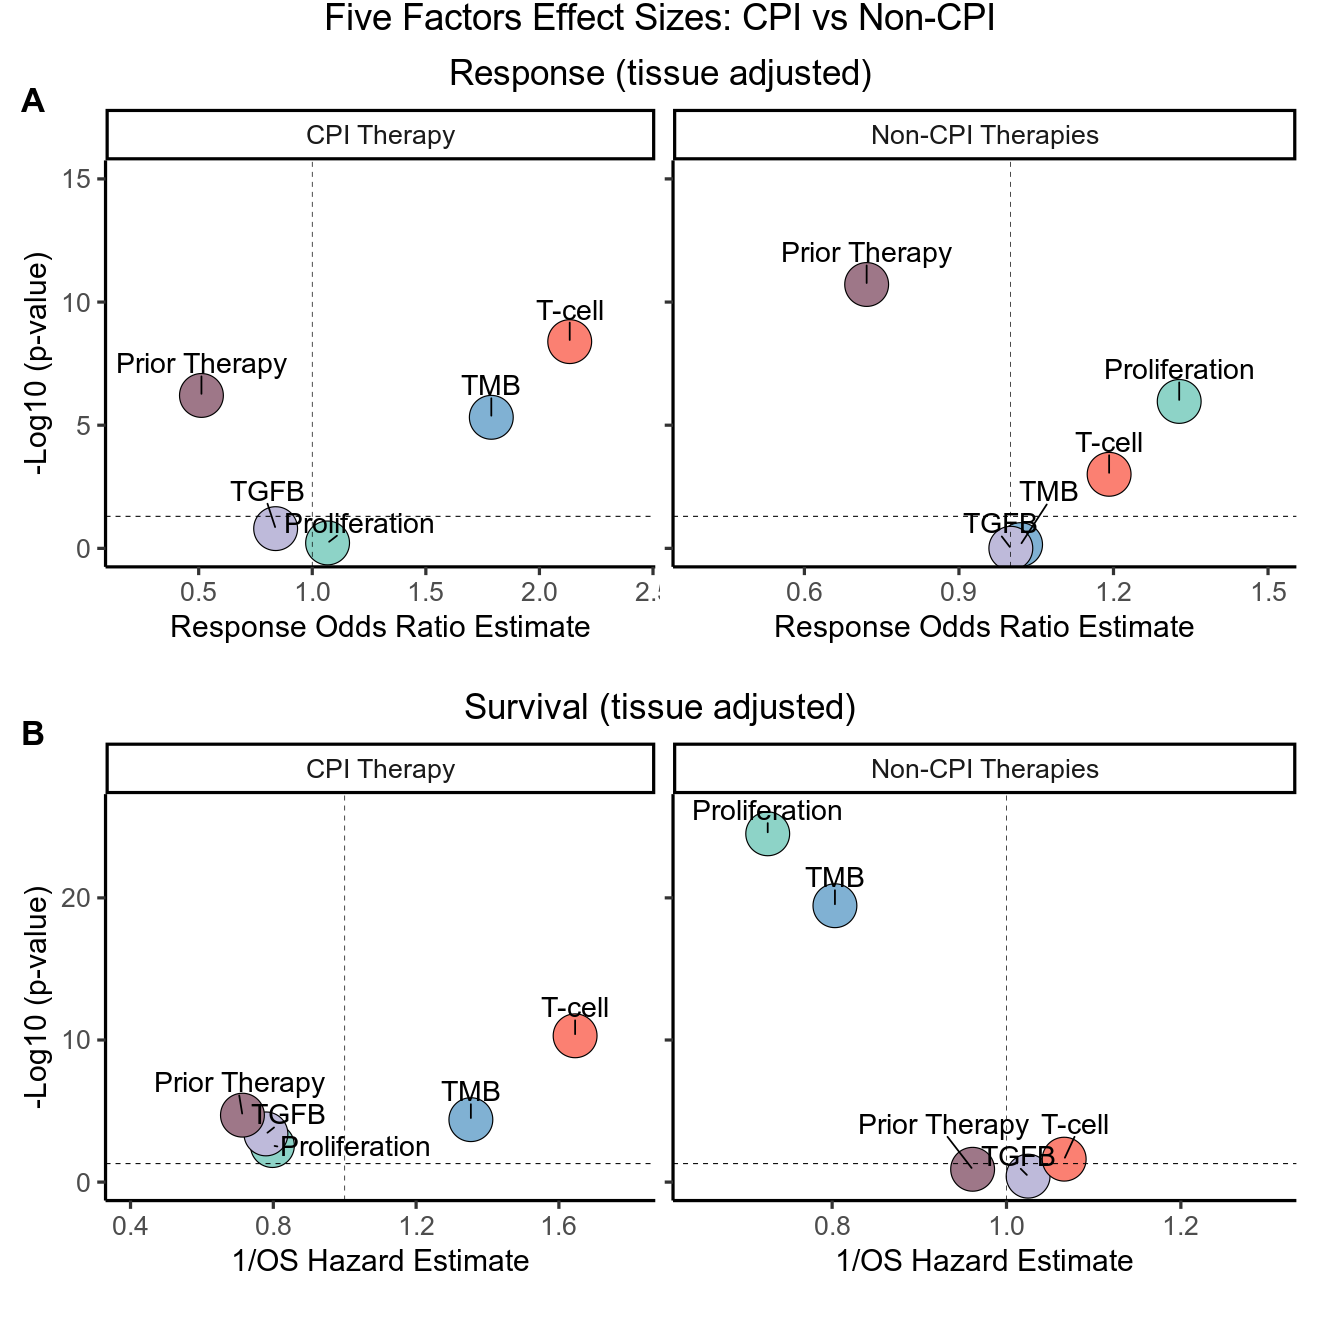

In [13]:
options(repr.plot.width=11, repr.plot.height= 11)
together
ggsave( paste0(FIG_FINAL_DIR, "2_supplement_main_non_hmf_effects.png"), width = 11, height = 11)